### Imports

In [1]:
import os
import torch
import seaborn as sns
import polars as pl
import polars.selectors as cs

from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Dataset Loading

In [2]:
ds = pl.read_csv('/kaggle/input/college-student-placement/college_student_placement_dataset.csv')

### EDA

In [3]:
ds.head()

College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
str,i64,f64,f64,i64,str,i64,i64,i64,str
"""CLG0030""",107,6.61,6.28,8,"""No""",8,8,4,"""No"""
"""CLG0061""",97,5.52,5.37,8,"""No""",7,8,0,"""No"""
"""CLG0036""",109,5.36,5.83,9,"""No""",3,1,1,"""No"""
"""CLG0055""",122,5.47,5.75,6,"""Yes""",1,6,1,"""No"""
"""CLG0004""",96,7.91,7.69,7,"""No""",8,10,2,"""No"""


In [4]:
ds.tail()

College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
str,i64,f64,f64,i64,str,i64,i64,i64,str
"""CLG0021""",119,8.41,8.29,4,"""No""",1,8,0,"""Yes"""
"""CLG0098""",70,9.25,9.34,7,"""No""",0,7,2,"""No"""
"""CLG0066""",89,6.08,6.25,3,"""Yes""",3,9,5,"""No"""
"""CLG0045""",107,8.77,8.92,3,"""No""",7,5,1,"""No"""
"""CLG0060""",109,9.41,9.77,8,"""No""",3,5,5,"""No"""


In [5]:
ds.describe()

statistic,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
str,str,f64,f64,f64,f64,str,f64,f64,f64,str
"""count""","""10000""",10000.0,10000.0,10000.0,10000.0,"""10000""",10000.0,10000.0,10000.0,"""10000"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0"""
"""mean""",null,99.4718,7.535673,7.532379,5.5464,null,4.9709,5.5618,2.5134,null
"""std""",null,15.053101,1.447519,1.470141,2.873477,null,3.160103,2.900866,1.715959,null
"""min""","""CLG0001""",41.0,5.0,4.54,1.0,"""No""",0.0,1.0,0.0,"""No"""
"""25%""",null,89.0,6.29,6.29,3.0,null,2.0,3.0,1.0,null
"""50%""",null,99.0,7.56,7.55,6.0,null,5.0,6.0,3.0,null
"""75%""",null,110.0,8.79,8.77,8.0,null,8.0,8.0,4.0,null
"""max""","""CLG0100""",158.0,10.0,10.46,10.0,"""Yes""",10.0,10.0,5.0,"""Yes"""


In [6]:
ds.dtypes

[String, Int64, Float64, Float64, Int64, String, Int64, Int64, Int64, String]

In [7]:
ds.null_count()

College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


### Dataset Preprocessing

In [8]:
str_cols = ds.select(cs.string())

for col in str_cols:
    if col.n_unique() > 10:
        str_cols = str_cols.drop(col.name)
        ds = ds.drop(col.name)

str_cols

Internship_Experience,Placement
str,str
"""No""","""No"""
"""No""","""No"""
"""No""","""No"""
"""Yes""","""No"""
"""No""","""No"""
…,…
"""No""","""Yes"""
"""No""","""No"""
"""Yes""","""No"""


In [9]:
key = {
    'No' : 0,
    'Yes' : 1
}

for col in str_cols:
    str_cols = str_cols.with_columns(
        pl.col(col.name).replace_strict(key).cast(pl.Float64).alias(col.name)
    )

str_cols

Internship_Experience,Placement
f64,f64
0.0,0.0
0.0,0.0
0.0,0.0
1.0,0.0
0.0,0.0
…,…
0.0,1.0
0.0,0.0
1.0,0.0


In [10]:
ds = ds.with_columns(str_cols)

ds

IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
i64,f64,f64,i64,f64,i64,i64,i64,f64
107,6.61,6.28,8,0.0,8,8,4,0.0
97,5.52,5.37,8,0.0,7,8,0,0.0
109,5.36,5.83,9,0.0,3,1,1,0.0
122,5.47,5.75,6,1.0,1,6,1,0.0
96,7.91,7.69,7,0.0,8,10,2,0.0
…,…,…,…,…,…,…,…,…
119,8.41,8.29,4,0.0,1,8,0,1.0
70,9.25,9.34,7,0.0,0,7,2,0.0
89,6.08,6.25,3,1.0,3,9,5,0.0


In [11]:
y = ds.drop_in_place('Placement').to_numpy()
x = ds

In [12]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=True)

### Sklearn

In [14]:
models = {
    'AdaBoostClassifier' : AdaBoostClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'MLPClassifier' : MLPClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'SVC' : SVC(),
    'LinearSVC' : LinearSVC()
}

accuracies = {
    'Models' : [],
    'Accuracies' : []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    accuracies['Models'].append(name)
    accuracies['Accuracies'].append(model.score(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### PyTorch

In [15]:
x_train, x_test = torch.from_numpy(x_train).to(torch.float64), torch.from_numpy(x_test).to(torch.float64)
y_train, y_test = torch.from_numpy(y_train).to(torch.float64), torch.from_numpy(y_test).to(torch.float64)
x_val, y_val = x_test[0:int(len(x_test)*0.2)], y_test[0:int(len(y_test)*0.2)]

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [16]:
class TorchModel(nn.Module):
    def __init__(self, input_size):
        super(TorchModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Dropout(p=0.5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x.squeeze(1)

In [17]:
model = TorchModel(input_size=8)
model.to(dtype=torch.float64)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
epochs = 50

In [18]:
train_loss_, val_loss_ = [],[]

print(f"Model is training\n")

for epoch in range(epochs):
    model.train()
    train_pbar = tqdm(enumerate(train_dataloader))
    for train_batch, (train_inputs, train_labels) in train_pbar:
        train_pbar.set_description(f"Epoch: {epoch}")
        
        optimizer.zero_grad()
        train_outputs = model(train_inputs)

        train_loss = loss_fn(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
    
    print(f"Train loss for epoch {epoch}: {train_loss}")
    train_loss_.append(train_loss)

    model.eval()
    val_pbar = tqdm(enumerate(val_dataloader))
    with torch.no_grad():
        for val_batch, (val_inputs, val_labels) in val_pbar:
            val_outputs = model(val_inputs)
            val_loss = loss_fn(val_outputs, val_labels)
    
    print(f"Val loss for epoch {epoch}: {val_loss}\n")
    val_loss_.append(val_loss)

print("Training Finished")

Model is training



Epoch: 0: : 250it [00:01, 203.40it/s]


Train loss for epoch 0: 0.5516163109856824


13it [00:00, 1011.76it/s]


Val loss for epoch 0: 0.4387836801943943



Epoch: 1: : 250it [00:01, 226.26it/s]


Train loss for epoch 1: 0.4124558768359895


13it [00:00, 1024.89it/s]


Val loss for epoch 1: 0.24177503100211947



Epoch: 2: : 250it [00:01, 219.45it/s]


Train loss for epoch 2: 0.4512686982478618


13it [00:00, 965.68it/s]


Val loss for epoch 2: 0.14864400622262117



Epoch: 3: : 250it [00:01, 215.83it/s]


Train loss for epoch 3: 0.310548168489719


13it [00:00, 1099.56it/s]


Val loss for epoch 3: 0.2967501249475586



Epoch: 4: : 250it [00:01, 210.35it/s]


Train loss for epoch 4: 0.33851987731468114


13it [00:00, 1084.34it/s]


Val loss for epoch 4: 0.21368167827305937



Epoch: 5: : 250it [00:01, 201.09it/s]


Train loss for epoch 5: 0.37506054994479177


13it [00:00, 1056.62it/s]


Val loss for epoch 5: 0.3038353705527323



Epoch: 6: : 250it [00:01, 222.39it/s]


Train loss for epoch 6: 0.49638892184482286


13it [00:00, 1143.03it/s]


Val loss for epoch 6: 0.12188842828397013



Epoch: 7: : 250it [00:01, 230.53it/s]


Train loss for epoch 7: 0.511331318066289


13it [00:00, 1116.90it/s]


Val loss for epoch 7: 0.16422927664988596



Epoch: 8: : 250it [00:01, 233.67it/s]


Train loss for epoch 8: 0.4668001868706921


13it [00:00, 1197.95it/s]


Val loss for epoch 8: 0.2160076833920157



Epoch: 9: : 250it [00:01, 232.19it/s]


Train loss for epoch 9: 0.5475665114683665


13it [00:00, 1102.02it/s]


Val loss for epoch 9: 0.10777972057975115



Epoch: 10: : 250it [00:01, 220.45it/s]


Train loss for epoch 10: 0.4441723815315065


13it [00:00, 1202.73it/s]


Val loss for epoch 10: 0.2272656000181071



Epoch: 11: : 250it [00:01, 230.98it/s]


Train loss for epoch 11: 0.41250306935844205


13it [00:00, 1037.76it/s]


Val loss for epoch 11: 0.2622580769474838



Epoch: 12: : 250it [00:01, 230.44it/s]


Train loss for epoch 12: 0.4251384966259249


13it [00:00, 1073.98it/s]


Val loss for epoch 12: 0.07607495086167375



Epoch: 13: : 250it [00:01, 232.17it/s]


Train loss for epoch 13: 0.32872797705703916


13it [00:00, 925.63it/s]


Val loss for epoch 13: 0.0940590823501993



Epoch: 14: : 250it [00:01, 230.80it/s]


Train loss for epoch 14: 0.4321029723692927


13it [00:00, 1093.52it/s]


Val loss for epoch 14: 0.2234749860805046



Epoch: 15: : 250it [00:01, 230.85it/s]


Train loss for epoch 15: 0.3959497434935455


13it [00:00, 1152.67it/s]


Val loss for epoch 15: 0.20514069445914912



Epoch: 16: : 250it [00:01, 227.12it/s]


Train loss for epoch 16: 0.45353763764607835


13it [00:00, 1066.46it/s]


Val loss for epoch 16: 0.14927176574939766



Epoch: 17: : 250it [00:01, 226.71it/s]


Train loss for epoch 17: 0.4622108509940188


13it [00:00, 1143.44it/s]


Val loss for epoch 17: 0.11743301126473596



Epoch: 18: : 250it [00:01, 238.37it/s]


Train loss for epoch 18: 0.4079154147293535


13it [00:00, 1164.36it/s]


Val loss for epoch 18: 0.022085015108163058



Epoch: 19: : 250it [00:01, 225.95it/s]


Train loss for epoch 19: 0.301740753467106


13it [00:00, 1112.34it/s]


Val loss for epoch 19: 0.08433233171388223



Epoch: 20: : 250it [00:01, 234.74it/s]


Train loss for epoch 20: 0.45354713097134036


13it [00:00, 1116.65it/s]


Val loss for epoch 20: 0.07967666098479644



Epoch: 21: : 250it [00:01, 228.29it/s]


Train loss for epoch 21: 0.21826572833679492


13it [00:00, 1098.78it/s]


Val loss for epoch 21: 0.0910833286606418



Epoch: 22: : 250it [00:01, 227.11it/s]


Train loss for epoch 22: 0.33490032958239924


13it [00:00, 1124.36it/s]


Val loss for epoch 22: 0.18751061723969903



Epoch: 23: : 250it [00:01, 229.88it/s]


Train loss for epoch 23: 0.3738930301236207


13it [00:00, 1135.65it/s]


Val loss for epoch 23: 0.05847839847958352



Epoch: 24: : 250it [00:01, 219.99it/s]


Train loss for epoch 24: 0.3969520925683998


13it [00:00, 1156.46it/s]


Val loss for epoch 24: 0.0610689455449662



Epoch: 25: : 250it [00:01, 224.88it/s]


Train loss for epoch 25: 0.3793868591154397


13it [00:00, 1040.69it/s]


Val loss for epoch 25: 0.14504155374852223



Epoch: 26: : 250it [00:01, 225.85it/s]


Train loss for epoch 26: 0.2816693556300482


13it [00:00, 735.92it/s]


Val loss for epoch 26: 0.0821331390023494



Epoch: 27: : 250it [00:01, 214.55it/s]


Train loss for epoch 27: 0.4421229684685888


13it [00:00, 1043.60it/s]


Val loss for epoch 27: 0.04111432051555543



Epoch: 28: : 250it [00:01, 213.65it/s]


Train loss for epoch 28: 0.3392410509613971


13it [00:00, 1095.07it/s]


Val loss for epoch 28: 0.11213544919917844



Epoch: 29: : 250it [00:01, 217.45it/s]


Train loss for epoch 29: 0.34681681926855834


13it [00:00, 975.82it/s]


Val loss for epoch 29: 0.016042344438483503



Epoch: 30: : 250it [00:01, 212.48it/s]


Train loss for epoch 30: 0.476710034270719


13it [00:00, 1149.25it/s]


Val loss for epoch 30: 0.05508110344287361



Epoch: 31: : 250it [00:01, 218.04it/s]


Train loss for epoch 31: 0.24936883882256805


13it [00:00, 1125.01it/s]


Val loss for epoch 31: 0.12058251239798594



Epoch: 32: : 250it [00:01, 216.73it/s]


Train loss for epoch 32: 0.303715484257291


13it [00:00, 996.13it/s]


Val loss for epoch 32: 0.19079611529820995



Epoch: 33: : 250it [00:01, 189.78it/s]


Train loss for epoch 33: 0.30955910156341915


13it [00:00, 741.58it/s]


Val loss for epoch 33: 0.012186721270826237



Epoch: 34: : 250it [00:01, 217.78it/s]


Train loss for epoch 34: 0.3312514023411796


13it [00:00, 1111.78it/s]


Val loss for epoch 34: 0.016799563915231464



Epoch: 35: : 250it [00:01, 226.98it/s]


Train loss for epoch 35: 0.4376529912771757


13it [00:00, 1008.84it/s]


Val loss for epoch 35: 0.09266824378840095



Epoch: 36: : 250it [00:01, 216.29it/s]


Train loss for epoch 36: 0.3956440409134234


13it [00:00, 978.39it/s]


Val loss for epoch 36: 0.05457917160549628



Epoch: 37: : 250it [00:01, 223.08it/s]


Train loss for epoch 37: 0.3480557519656833


13it [00:00, 1106.16it/s]


Val loss for epoch 37: 0.06700956312813353



Epoch: 38: : 250it [00:01, 211.47it/s]


Train loss for epoch 38: 0.33382943631837536


13it [00:00, 1179.14it/s]


Val loss for epoch 38: 0.05473366878097194



Epoch: 39: : 250it [00:01, 227.13it/s]


Train loss for epoch 39: 0.4161541388289981


13it [00:00, 1264.66it/s]


Val loss for epoch 39: 0.016314170921784606



Epoch: 40: : 250it [00:01, 225.43it/s]


Train loss for epoch 40: 0.28635129431613054


13it [00:00, 1131.60it/s]


Val loss for epoch 40: 0.13856588914701104



Epoch: 41: : 250it [00:01, 223.18it/s]


Train loss for epoch 41: 0.4617061608716001


13it [00:00, 1058.02it/s]


Val loss for epoch 41: 0.031604974586760565



Epoch: 42: : 250it [00:01, 224.99it/s]


Train loss for epoch 42: 0.32762535949281146


13it [00:00, 1094.68it/s]


Val loss for epoch 42: 0.01817515333665218



Epoch: 43: : 250it [00:01, 223.59it/s]


Train loss for epoch 43: 0.32603334971559966


13it [00:00, 1072.61it/s]


Val loss for epoch 43: 0.1143984284847884



Epoch: 44: : 250it [00:01, 224.31it/s]


Train loss for epoch 44: 0.3126512157193775


13it [00:00, 1045.98it/s]


Val loss for epoch 44: 0.11511246487956896



Epoch: 45: : 250it [00:01, 216.19it/s]


Train loss for epoch 45: 0.3298826367940507


13it [00:00, 985.36it/s]


Val loss for epoch 45: 0.05316357883598166



Epoch: 46: : 250it [00:01, 223.33it/s]


Train loss for epoch 46: 0.3559217011132787


13it [00:00, 1047.65it/s]


Val loss for epoch 46: 0.018095538248953262



Epoch: 47: : 250it [00:01, 212.38it/s]


Train loss for epoch 47: 0.282579395438477


13it [00:00, 1050.92it/s]


Val loss for epoch 47: 0.09417954220565805



Epoch: 48: : 250it [00:01, 221.50it/s]


Train loss for epoch 48: 0.3251859915293955


13it [00:00, 869.62it/s]


Val loss for epoch 48: 0.022878829671347852



Epoch: 49: : 250it [00:01, 216.91it/s]


Train loss for epoch 49: 0.4349157321476518


13it [00:00, 1175.10it/s]

Val loss for epoch 49: 0.01885728156948279

Training Finished


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, 'Loss over time for PyTorch model')

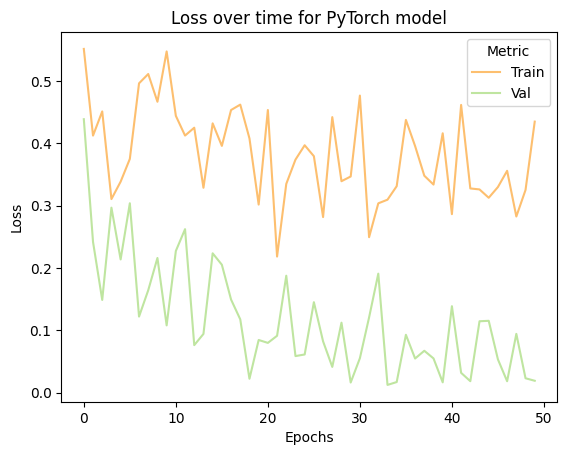

In [19]:
loss_history = pl.DataFrame({'Epochs' : range(0, 50), 'Train' : train_loss_, 'Val' : val_loss_})
loss_history = loss_history.unpivot(index='Epochs', variable_name='Metric', value_name='Loss')
ad = sns.lineplot(x='Epochs', y='Loss', hue='Metric', data=loss_history, palette='Spectral')
ad.set_title('Loss over time for PyTorch model')

In [20]:
model.eval()
with torch.no_grad():
    test_input, test_label = next(iter(test_dataloader))
    test_output = model(test_input)
    preds = (test_output > 0.5).to(torch.int)
    accuracies['Models'].append('PyTorch')
    accuracies['Accuracies'].append(accuracy_score(test_label, preds))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Accuracies from Models')

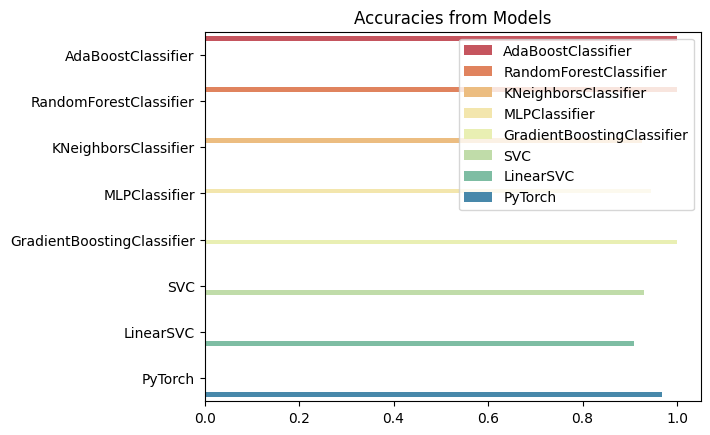

In [21]:
ax = sns.barplot(x="Accuracies", y="Models", data=accuracies, hue="Models", palette="Spectral")
ax.set_title("Accuracies from Models")